In [20]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
from crashpy.utilities import crashMemMap

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### redshift_to_snap(redshift)
Simple function which converts a redshift into the corresponing snapshot name to easily construct the path to the halo

**Parameters**:
- **redshift**: Redshift you want to convert (has to be 6,8 or 10)

**Returns**:
- **snapname**: Name of the snapshot the **redshift** corresponds to

In [18]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

### get_paths(halo_id, conf, redshift)
Constructs the path to the output of the simulation as well as to the density map

**Parameters**:
- **halo_id**: ID of the halo to which you want to determine the path
- **conf**: Configuration of the simulation e.g. 'fid2' 
- **redshift**: Redshift of the halo you want to examine

**Returns**:
- **simulation_path**: Path to the output maps of the simulation
- **density_path**: Path to the density used in the simulation

In [26]:
def get_paths(halo_id, conf, redshift):
    snap = redshift_to_snap(redshift)
    conf_dir = os.path.join('/ptmp/mpa/mglatzle/TNG_f_esc', conf)
    simulation_path =  os.path.join(conf_dir, f'run/L35n2160TNG/{snap}/g{halo_id}/Output/phys_ic00_rt05.out')
    dens_path =  os.path.join(conf_dir, f'run/L35n2160TNG/{snap}/g{halo_id}/Input/dens_ic00.in')
    return simulation_path, dens_path

### get_H_map(halo)
Simple function to calculate a map for xHI from xHII
**Parameters**:
- **halo**: Output of a simulation which should not be manipulated to ensure the map with index 1 is the HII map

**Returns**:
- **xHI**: Map containing the distribution of xHI

In [6]:
def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

### get_He_map(halo)
Simple function to calculate a map for xHeI from xHeII and xHeII
**Parameters**:
- **halo**: Output of a simulation which should not be manipulated to ensure the map with index 2 and 3 are the HeII and HeII maps respectively

**Returns**:
- **xHeI**: Map containing the distribution of xHeI

In [7]:
def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

### get_slice(cube, axis)
Function which cuts out a slice from the center of the map along a given axis
**Parameters**:
- **cube**: Simulation map
- **axis**: Axis along which you want to slice the halo

**Returns**:
- **map_slice**: Slice through the center of the map

In [59]:
def get_slice(cube, axis, method = 'slice', density = None):
    center = cube.shape[0]//2
    if method == 'slice':
        if axis == 0:
            map_slice = cube[center,...]
        elif axis == 1:
            map_slice = cube[:, center, :]
        elif axis == 2:
            map_slice = cube[:,:,center]
        else:
            raise ValueError('Axis number out of bounds')
    else:
        map_slice = get_projection(cube, axis=axis, method=method, density=density)
    return map_slice

In [79]:
def get_projection(cube, axis, method, density):
    if method == 'line_average':
        map_slice = np.sum(cube, axis=axis)/cube.shape[0]
    elif method == 'density_average':
        dens_weighted = cube*density
        map_slice = np.sum(dens_weighted, axis=axis)/np.sum(density, axis=axis)
    elif method == 'test':
        dens_weighted = cube*density
        map_slice_dens = np.sum(dens_weighted, axis=axis)/np.sum(density, axis=axis)
        map_slice_lin = np.sum(cube, axis=axis)/cube.shape[0]
        map_slice = map_slice_lin-map_slice_dens
    else:
        error_message = f'Method {method} is not implemented'
        raise NotImplementedError(error_message)
    return map_slice

### print_data(maps)
Returns statistical information about the maps being examined

**Parameters**:
- **maps**: Dictionary of maps for which the statistical information is returned

In [56]:
def print_data(maps):
    for i, key in enumerate(maps):
        if i == 0:
            print(f'This halo has the shape {maps[key].shape}.')
            print('*'*85)
            
        maxi = np.max(maps[key])
        mini = np.min(maps[key])
        average = np.average(maps[key])
        median = np.median(maps[key])
        print(f'''For {key} the max value is {maxi:.2f}, the min value is {mini:.2f}
        , the average is {average:.2f} and the median is {median:.2f}.''')
        print('*'*85)
    return

### get_maps(halo_id, conf, redshift, props, get_data=False)
Returns the density, temperature and ionization maps of a halo

**Parameters**:
- **halo_id**: ID of the halo to which you want to determine the path
- **conf**: Configuration of the simulation e.g. 'fid2' 
- **redshift**: Redshift of the halo you want to examine
- **props**: Properties for which you want to obtain the maps
- **get_data**: Should a statistical summary of the maps be printed out (default: False)


**Returns**:
- **maps**: Dictionary containing **props** as keys and the corresponding maps as values

In [47]:
def get_maps(halo_id, conf, redshift, props, get_data=False):
    prop_dict = {'T':0, 'xHII':1, 'xHeII':2, 'xHeIII':3}
    sim_path, dens_path = get_paths(halo_id, conf, redshift) 
    halo = crashMemMap(sim_path, 'all')
    dens = crashMemMap(dens_path, 'all')
    
    maps = {}
    for prop in props:
        if prop in prop_dict:
            if prop != 'T':
                maps[prop] = halo[prop_dict[prop]]
            else:
                maps[prop] = np.log10(halo[prop_dict[prop]])
        elif prop == 'xHI':
            maps[prop] = get_H_map(halo)
        elif prop == 'xHeI':
            maps[prop] = get_He_map(halo)
        elif prop == 'dens':
            maps[prop] = np.log10(dens[0])
        else:
            raise ValueError(f'The property {prop} does not exist.')
    
    if get_data:
        print_data(maps)
        
    return maps

### plot_maps(halo_id, conf, redshift, props, axis=0)
Plots slices of the maps of props 

**Parameters**:
- **halo_id**: ID of the halo to which you want to determine the path
- **conf**: Configuration of the simulation e.g. 'fid2' 
- **redshift**: Redshift of the halo you want to examine
- **props**: Properties for which you want to obtain the maps
- **axis**: Axis along which you want to slice the halo


In [71]:
def plot_maps(halo_id, conf, redshift, props, axis=0, method='slice'):
    maps = get_maps(halo_id, conf, redshift, props)
    f, axarr = plt.subplots(int(np.ceil(len(props)/2)), 2)
    for i,key in enumerate(maps):
        subfig = axarr[i//2, i%2].imshow(get_slice(maps[key], axis, density=maps['dens'], method=method))
        axarr[i//2, i%2].axis('off')
        if props[i] != ('T' or 'dens'):
            axarr[i//2, i%2].set_title(props[i], size=30)
        elif props[i] == 'dens':
            axarr[i//2, i%2].set_title('$\log(\rho)$', size=30)
        else:
            axarr[i//2, i%2].set_title('log(T)', size=30)
        divider = make_axes_locatable(axarr[i//2, i%2])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        f.colorbar(subfig, cax=cax)
        
    plt.rcParams["figure.figsize"] = (20,25)
    plt.tight_layout(h_pad=1)
    plt.show()
    return

### update_df(df)
Simple function which updates the loaded dataframe with three additional columns for further analysis these clumns are **'Q0/HaloMass'** (total halo luminosity of halo mass), **'R_v^3/HaloMass'** (virial radius to the third power divided by the halo mass) and **'StarMass'** (just the mass of the stars in the halo)

**Parameters**:
- **df**: Dataframe that needs to be updated

**Returns**:

In [11]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    return

In [12]:
df = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
update_df(df)

In [54]:
df.iloc[4]

ID                                                              1360
z                                                                  6
HaloMass                                                     1.56813
Metallicity                                               0.00175389
FractionStars                                             0.00293145
FractionGas                                                 0.112949
FractionDust                                             3.30692e-05
Q0                                                       1.22249e+53
aStar                                                    2.00044e+08
HaloRadii                                                    59.0737
f_esc                                                      0.0157679
Temperature                                                   234383
xHII                                                        0.861999
xHeII                                                       0.130291
xHeIII                            

In [58]:
59.0737*2

118.1474

In [16]:
props = ['T', 'dens', 'xHII', 'xHeII', 'xHeIII']

In [57]:
_ = get_maps(1360, 'fid2', 6, props=props, get_data=True)

This halo has the shape (216, 216, 216).
*************************************************************************************
For T the max value is 6.46, the min value is 3.00
        , the average is 5.08 and the median is 5.26.
*************************************************************************************
For dens the max value is 0.73, the min value is -4.38
        , the average is -2.85 and the median is -2.99.
*************************************************************************************
For xHII the max value is 1.00, the min value is 0.00
        , the average is 0.86 and the median is 1.00.
*************************************************************************************
For xHeII the max value is 1.00, the min value is 0.00
        , the average is 0.13 and the median is 0.00.
*************************************************************************************
For xHeIII the max value is 1.00, the min value is 0.00
        , the average is 0.66 and the me

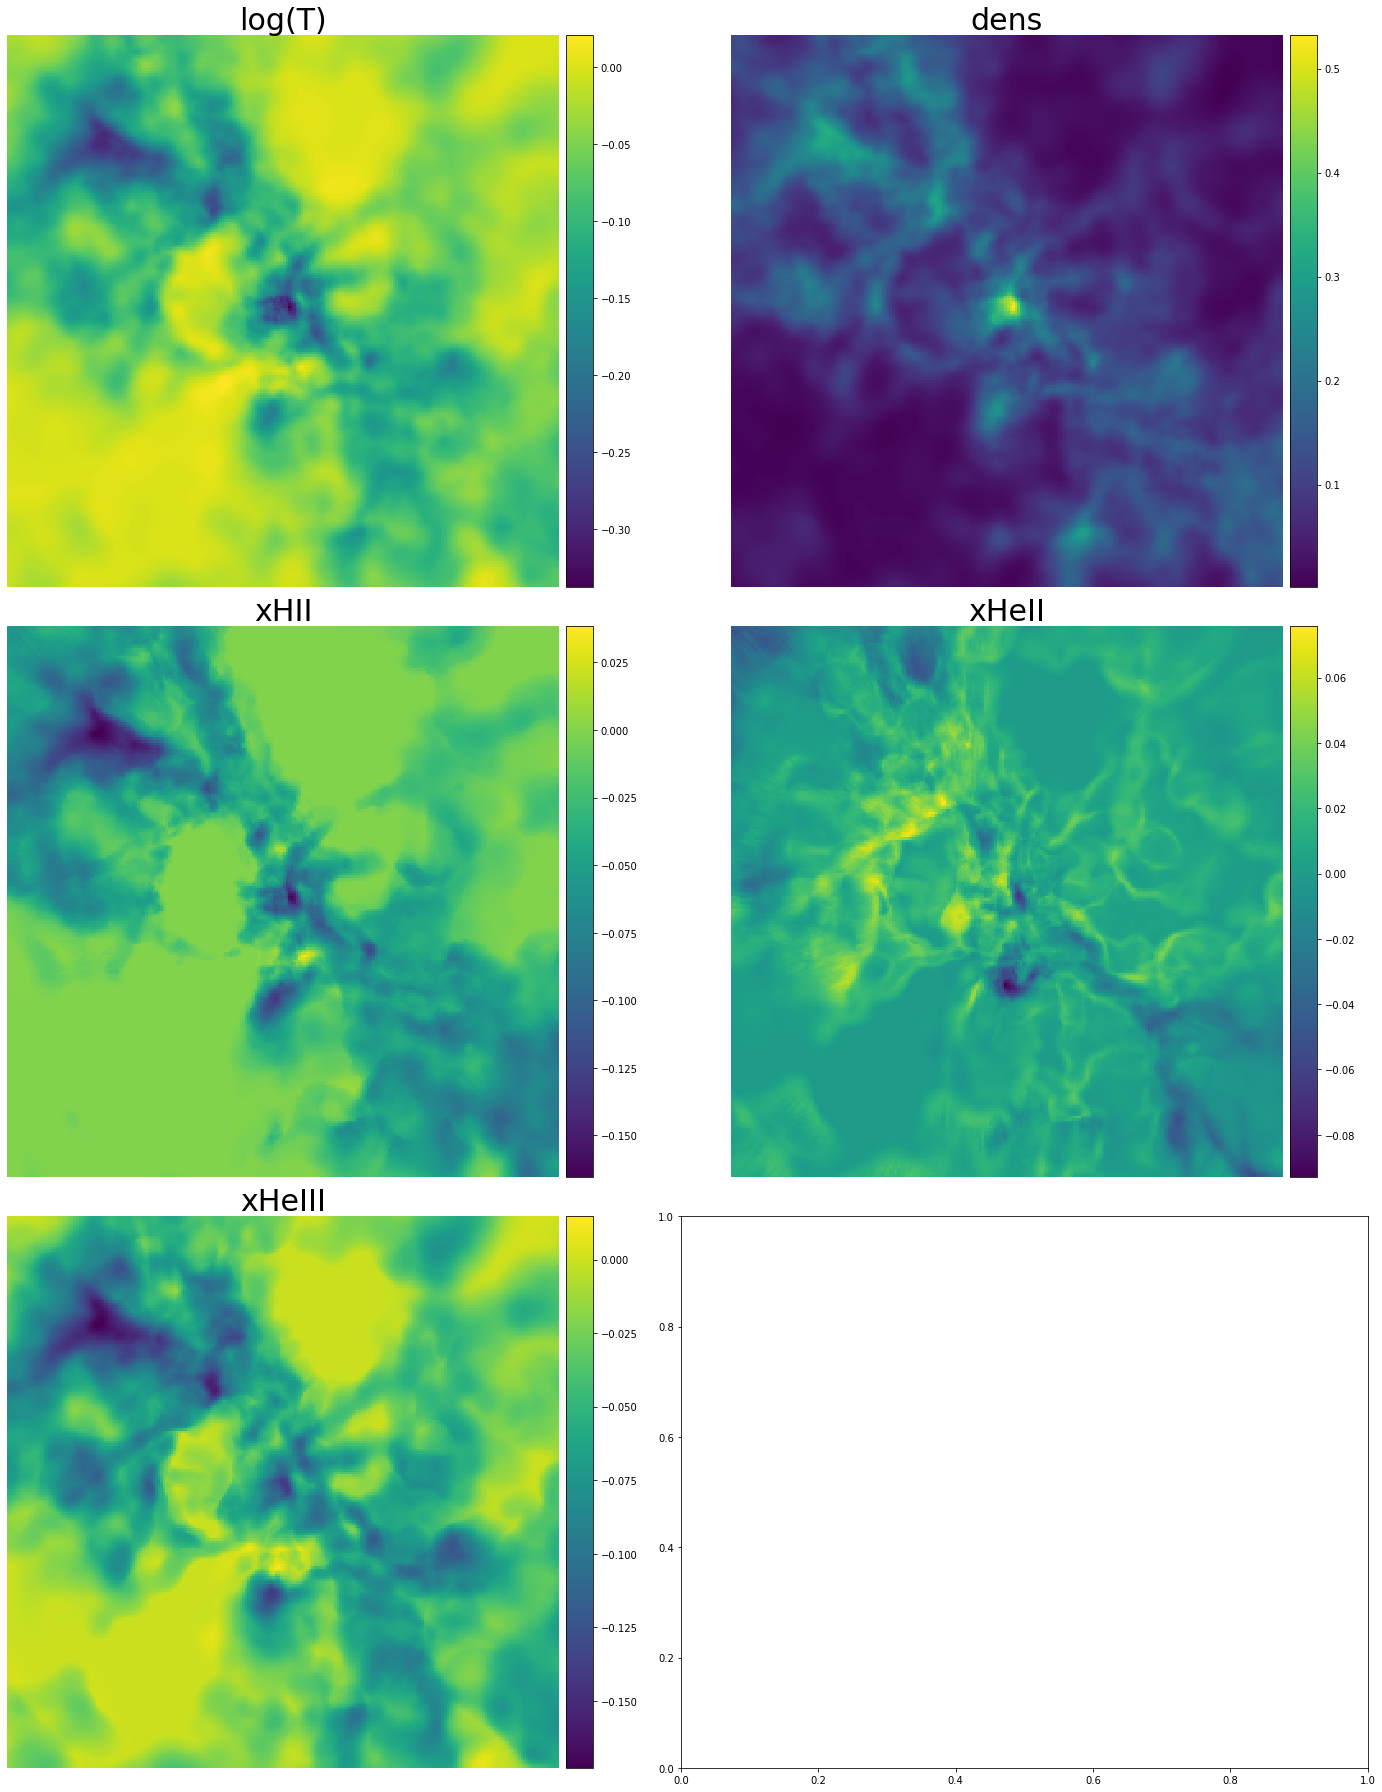

In [80]:
plot_maps(1360, 'fid2', 6, props=props, axis=0, method='test')

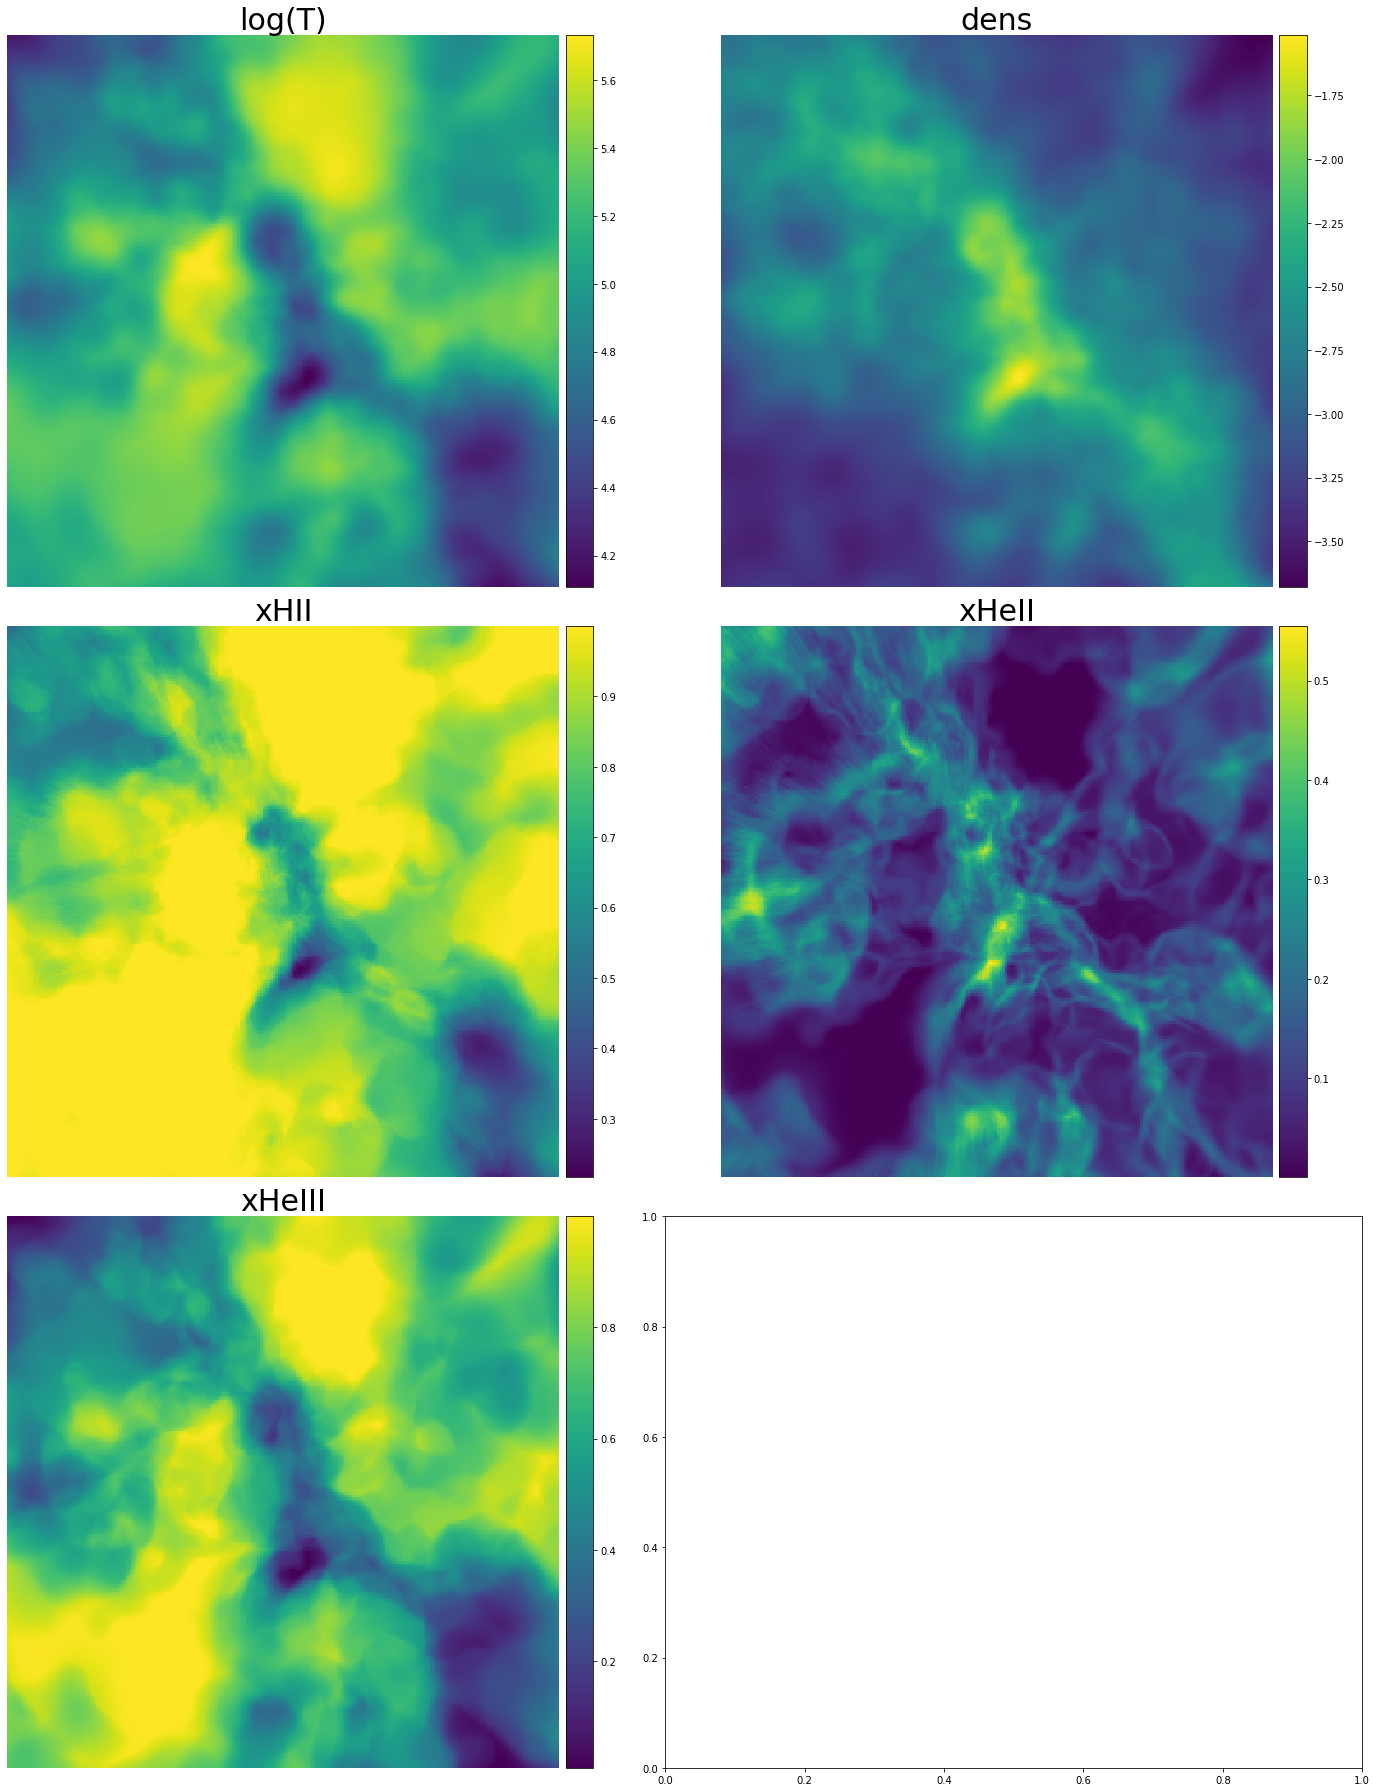

In [73]:
plot_maps(1360, 'fid2', 6, props=props, axis=0, method='line_average')

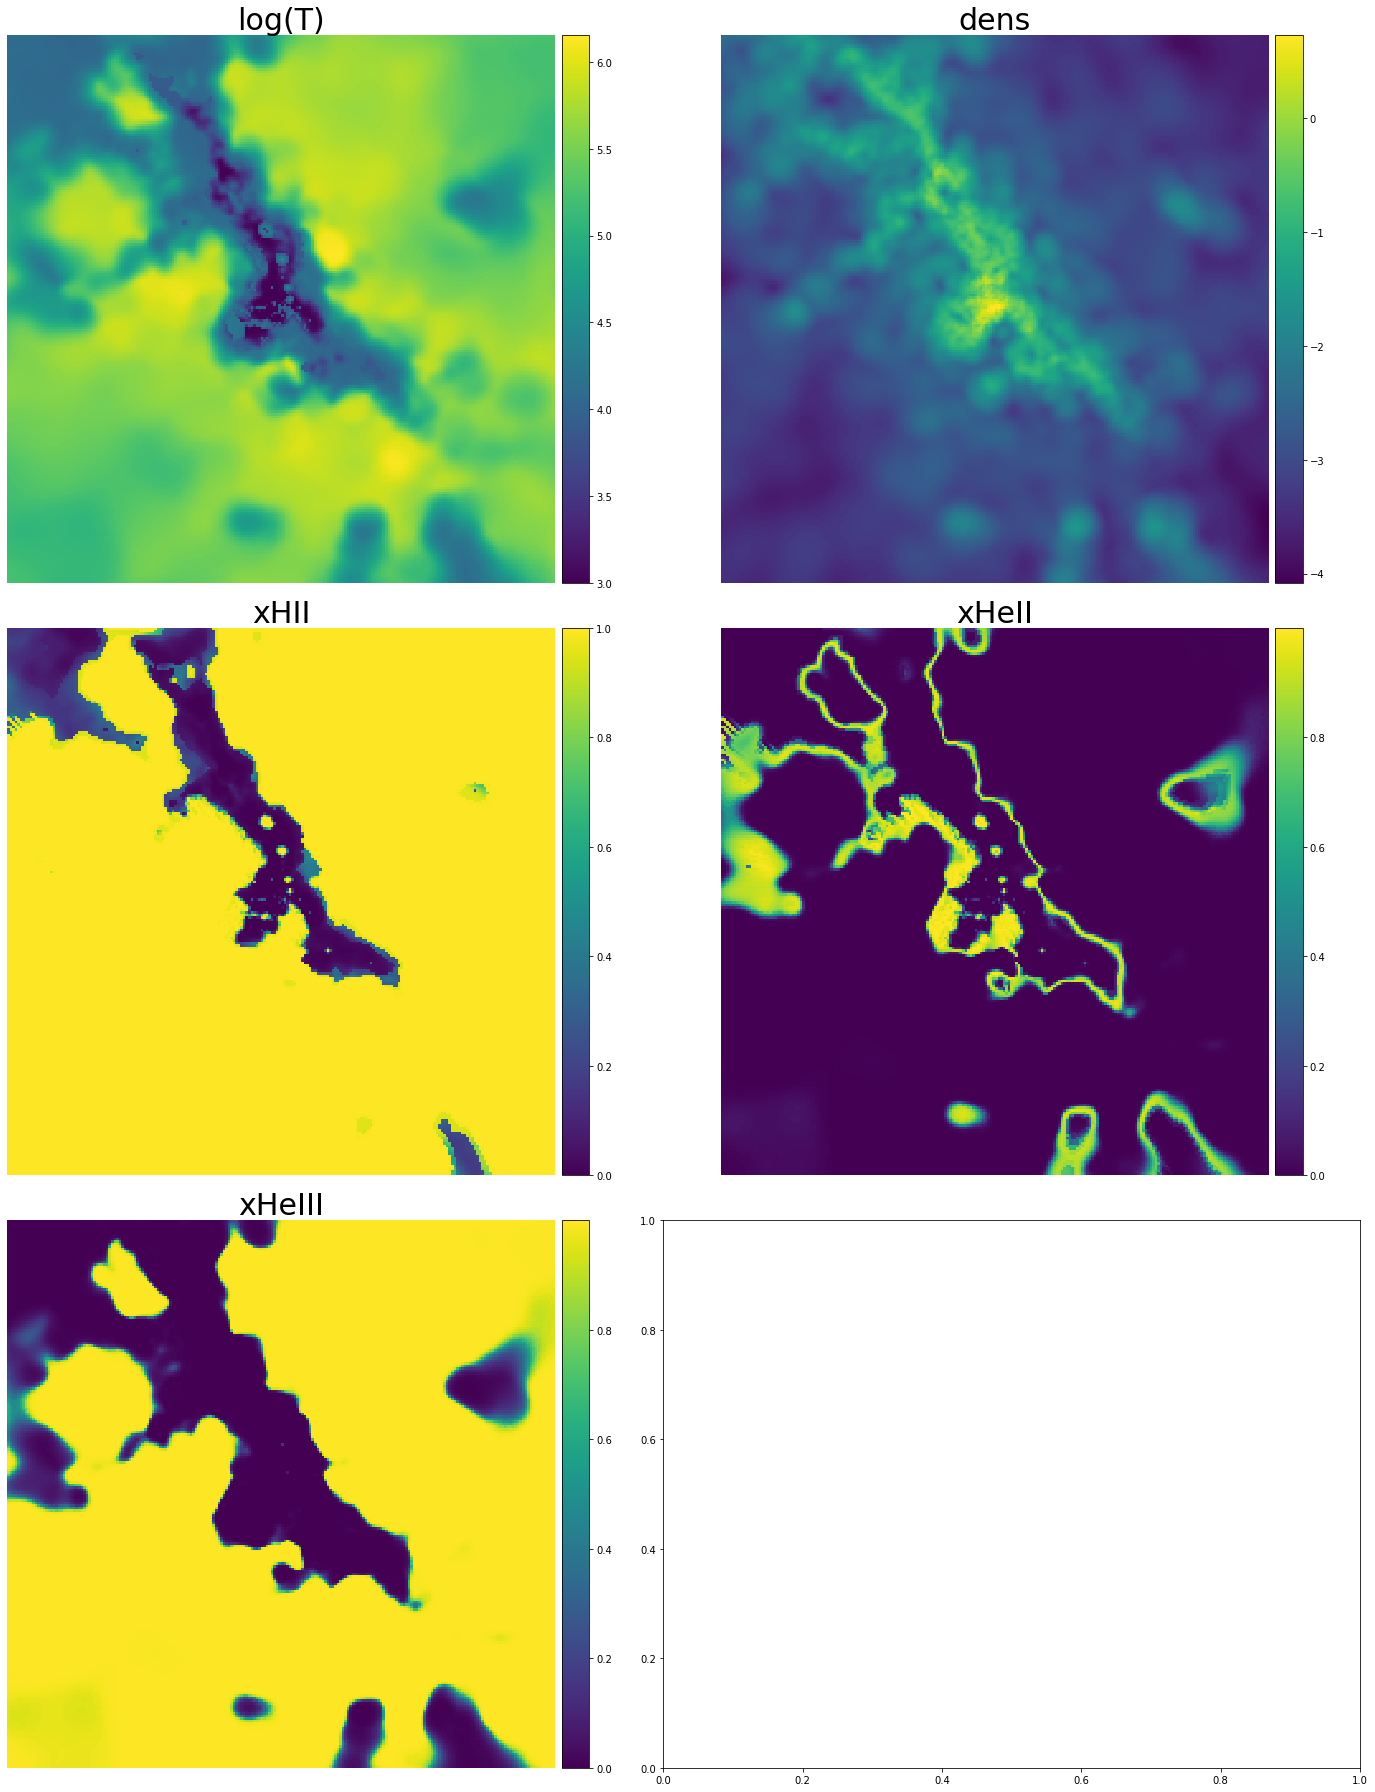

In [74]:
plot_maps(1360, 'fid2', 6, props=props, axis=0)